### 8. juli 

Hvilken fordeling har vektendringene som skjer over tid i det første laget til det nevrale nettverket definert i koden under? Det prøver jeg å finne ut. 

Er det en eksponentialfordeling?
$$P(\Delta w) = C e^{-\frac{\Delta w}{\Delta w^*}}$$
hvor $\Delta w$ er vektendringen, $C$ er en konstant og $\Delta w^*$ er den karakteristiske lengden/størrelsen.

en logaritmisk fordeling?
$$\log_{10} P = \log_{10} C - \frac{\Delta w}{\Delta w^*}$$

eller en log-normal-fordeling?
$$\ln P \rightarrow e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$$


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

Tester litt hvordan eksponentialfunksjonen oppfører seg med ulike input:

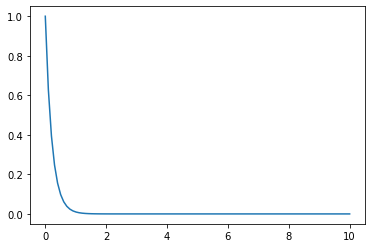

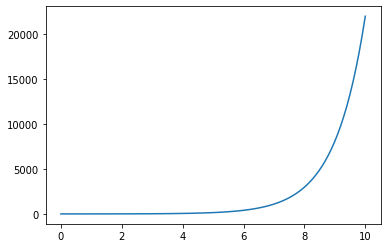

In [3]:
x = np.linspace(0, 10, 100)
def f(x, a):
    return a**x

def g(x):
    return np.exp(x)

plt.plot(x, f(x, 0.01))
plt.show()

plt.plot(x, g(x))
plt.show()

Tester log-funksjonen med ulike input:

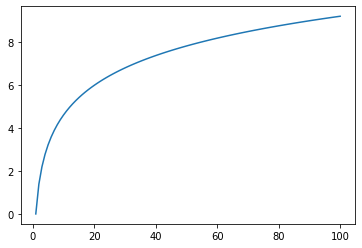

In [4]:
x = np.linspace(1, 100, 100)
def f(x, a):
    return a * np.log((x))

plt.plot(x, f(x, 2))
plt.show()

Hyperparameterne er like de fra 01-04_07_23.ipynb, da jeg i denne notebooken ønsker å se videre på sannsynlighetstetthetene og hvilken funksjon de kan passe. Jeg velger her å utelate histogrammene i plottingen, men ellers er koden helt lik.

In [5]:
# Hyperparameters
input_dim = 28**2  # MNIST images are 28x28 pixels
hidden_dim1 = 28**2 #128  # Number of units in the first hidden layer
hidden_dim2 = 28**2 #100  # Number of units in the second hidden layer
learning_rate = 0.01
output_dim = 10  # Initial output classes 
batch_size = 64

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, output_dim)
        self.R = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.R(self.layer1(x))
        x = self.R(self.layer2(x))
        x = self.layer3(x)
        return x

In [7]:
# Normalizes the data like I did earlier by dividing by 255.0
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Create an instance of the network
model = Net()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
# Set random seed for reproducibility
torch.manual_seed(43)

num_epochs = 30

# Track the weight differences
weight_differences_0_1 = []
weight_differences_9_10 = []
weight_differences_29_30 = []
initial_weights = None


In [10]:
# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Save the weight differences for the desired epochs
    if epoch == 0:
        initial_weights = model.layer1.weight.data.clone()
    elif epoch == 1:
        final_weights = model.layer1.weight.data.clone()
        weight_diff = torch.abs(final_weights - initial_weights)
        weight_differences_0_1.extend(weight_diff.view(-1).detach().numpy())
    elif epoch == 9:
        final_weights = model.layer1.weight.data.clone()
        weight_diff = torch.abs(final_weights - initial_weights)
        weight_differences_9_10.extend(weight_diff.view(-1).detach().numpy())
    elif epoch == 29:
        final_weights = model.layer1.weight.data.clone()
        weight_diff = torch.abs(final_weights - initial_weights)
        weight_differences_29_30.extend(weight_diff.view(-1).detach().numpy())

    print(f"Epoch [{epoch + 1}/{num_epochs}]")


Epoch [1/30]
Epoch [2/30]
Epoch [3/30]
Epoch [4/30]
Epoch [5/30]
Epoch [6/30]
Epoch [7/30]
Epoch [8/30]
Epoch [9/30]
Epoch [10/30]
Epoch [11/30]
Epoch [12/30]
Epoch [13/30]
Epoch [14/30]
Epoch [15/30]
Epoch [16/30]
Epoch [17/30]
Epoch [18/30]
Epoch [19/30]
Epoch [20/30]
Epoch [21/30]
Epoch [22/30]
Epoch [23/30]
Epoch [24/30]
Epoch [25/30]
Epoch [26/30]
Epoch [27/30]
Epoch [28/30]
Epoch [29/30]
Epoch [30/30]


In [11]:
plt.rcParams.update({'font.size': 12})

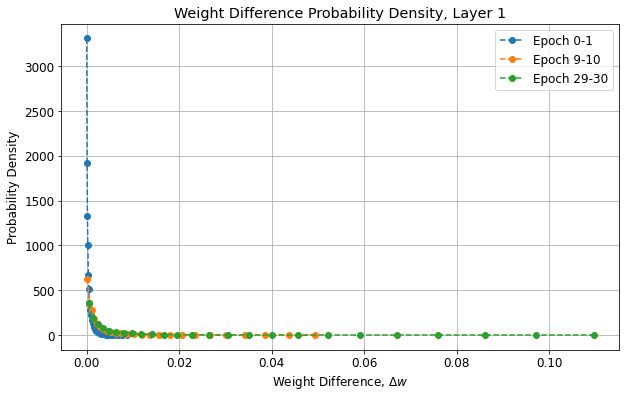

In [12]:
# Define the number of bins and the scaling factor for increasing bin widths
num_bins = 25
bin_width_scale = 15

# Calculate the scaling factor for each bin
bin_scaling = np.exp(np.linspace(0, np.log(bin_width_scale), num_bins))

# Insert 0 as the first element of bin_scaling
bin_scaling = np.insert(bin_scaling, 0, 0)

# Calculate the bin edges
bin_edges = np.cumsum(bin_scaling)
bin_edges /= bin_edges[-1]
bin_edges *= np.max(weight_differences_0_1)  # Use the maximum weight difference from epoch 0-1

# Calculate probability density for epoch 0-1
hist_0_1, _ = np.histogram(weight_differences_0_1, bins=bin_edges, density=False)
bin_centers_0_1 = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths_0_1 = np.diff(bin_edges)
prob_density_0_1 = hist_0_1 / (bin_widths_0_1 * np.sum(hist_0_1))

# Repeat the same process for epoch 9-10
bin_edges = np.cumsum(bin_scaling)
bin_edges /= bin_edges[-1]
bin_edges *= np.max(weight_differences_9_10)  # Use the maximum weight difference from epoch 9-10

# Calculate probability density for epoch 9-10
hist_9_10, _ = np.histogram(weight_differences_9_10, bins=bin_edges, density=False)
bin_centers_9_10 = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths_9_10 = np.diff(bin_edges)
prob_density_9_10 = hist_9_10 / (bin_widths_9_10 * np.sum(hist_9_10))

# Repeat the same process for epoch 29-30
bin_edges = np.cumsum(bin_scaling)
bin_edges /= bin_edges[-1]
bin_edges *= np.max(weight_differences_29_30)  # Use the maximum weight difference from epoch 29-30

# Calculate probability density for epoch 29-30
hist_29_30, _ = np.histogram(weight_differences_29_30, bins=bin_edges, density=False)
bin_centers_29_30 = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths_29_30 = np.diff(bin_edges)
prob_density_29_30 = hist_29_30 / (bin_widths_29_30 * np.sum(hist_29_30))

# Plot all histograms and probability functions in one plot
plt.figure(figsize=(10, 6))

# Plot the probability density curves
plt.plot(bin_centers_0_1, prob_density_0_1, "o--", label="Epoch 0-1")
plt.plot(bin_centers_9_10, prob_density_9_10, "o--", label="Epoch 9-10")
plt.plot(bin_centers_29_30, prob_density_29_30, "o--", label="Epoch 29-30")

plt.xlabel("Weight Difference, $\Delta w$")
plt.ylabel("Probability Density")
plt.title("Weight Difference Probability Density, Layer 1")
plt.legend()
plt.grid()
plt.show()

Som vi ser, er det kun et mindre område hvor vi ser alle de tre sannsynlighetstetthetene. Zoomer derfor inn på dette området:

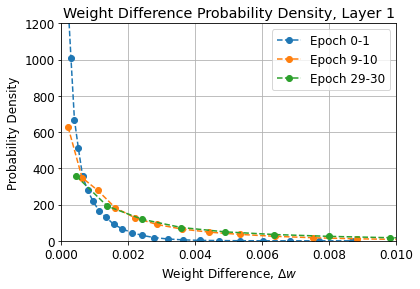

In [13]:
plt.plot(bin_centers_0_1, prob_density_0_1, "o--", label="Epoch 0-1")
plt.plot(bin_centers_9_10, prob_density_9_10, "o--", label="Epoch 9-10")
plt.plot(bin_centers_29_30, prob_density_29_30, "o--", label="Epoch 29-30")

plt.xlabel("Weight Difference, $\Delta w$")
plt.ylabel("Probability Density")
plt.title("Weight Difference Probability Density, Layer 1")
plt.legend()
plt.grid()
plt.xlim(0, 0.01)
plt.ylim(0, 1200)
plt.show()

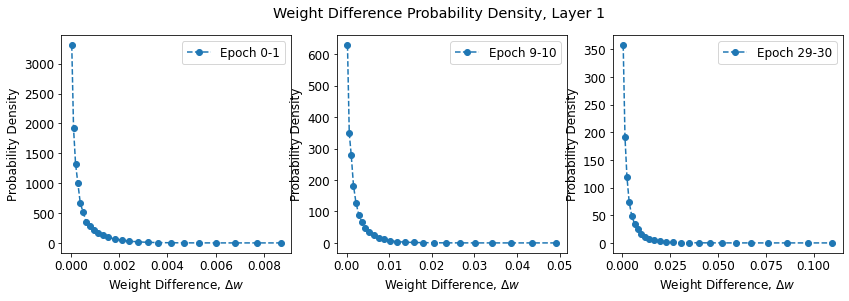

In [14]:
plt.figure(figsize=(14, 4))
plt.suptitle("Weight Difference Probability Density, Layer 1")

plt.subplot(1, 3, 1)
plt.plot(bin_centers_0_1, prob_density_0_1, "o--", label="Epoch 0-1")
plt.legend()
plt.xlabel("Weight Difference, $\Delta w$")
plt.ylabel("Probability Density")

plt.subplot(1, 3, 2)
plt.plot(bin_centers_9_10, prob_density_9_10, "o--", label="Epoch 9-10")
plt.legend()
plt.xlabel("Weight Difference, $\Delta w$")
plt.ylabel("Probability Density")

plt.subplot(1, 3, 3)
plt.plot(bin_centers_29_30, prob_density_29_30, "o--", label="Epoch 29-30")
plt.legend()
plt.xlabel("Weight Difference, $\Delta w$")
plt.ylabel("Probability Density")
plt.show()

Ser at selv etter trening av nettverket ser fordelingen nesten helt lik ut. Det eneste som endres er hvor mange vektendringer som gjøres mellom epokene.

Prøver logaritmisk fremstilling

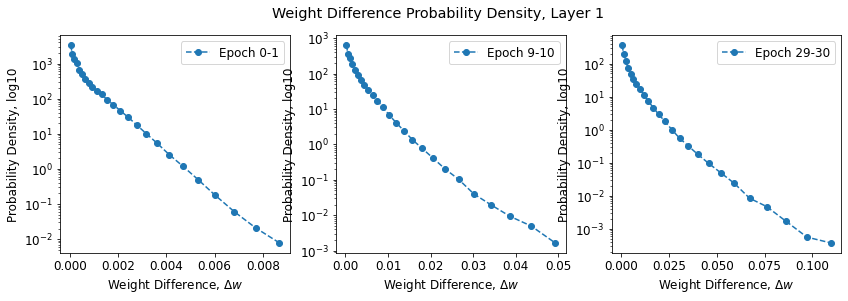

In [15]:
plt.figure(figsize=(14, 4))
plt.suptitle("Weight Difference Probability Density, Layer 1")

plt.subplot(1, 3, 1)
plt.plot(bin_centers_0_1, prob_density_0_1, "o--", label="Epoch 0-1")
plt.legend()
plt.yscale("log")
plt.xlabel("Weight Difference, $\Delta w$")
plt.ylabel("Probability Density, log10")

plt.subplot(1, 3, 2)
plt.plot(bin_centers_9_10, prob_density_9_10, "o--", label="Epoch 9-10")
plt.legend()
plt.yscale("log")
plt.xlabel("Weight Difference, $\Delta w$")
plt.ylabel("Probability Density, log10")

plt.subplot(1, 3, 3)
plt.plot(bin_centers_29_30, prob_density_29_30, "o--", label="Epoch 29-30")
plt.legend()
plt.yscale("log")
plt.xlabel("Weight Difference, $\Delta w$")
plt.ylabel("Probability Density, log10")
plt.show()

Tilnærmet lineær graf i log-log plot antyder ekspoentiell sammenheng.

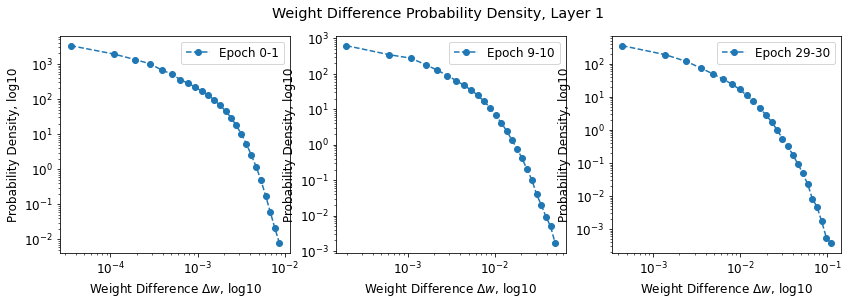

In [16]:
plt.figure(figsize=(14, 4))
plt.suptitle("Weight Difference Probability Density, Layer 1")

plt.subplot(1, 3, 1)
plt.plot(bin_centers_0_1, prob_density_0_1, "o--", label="Epoch 0-1")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Weight Difference $\Delta w$, log10")
plt.ylabel("Probability Density, log10")

plt.subplot(1, 3, 2)
plt.plot(bin_centers_9_10, prob_density_9_10, "o--", label="Epoch 9-10")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Weight Difference $\Delta w$, log10")
plt.ylabel("Probability Density, log10")

plt.subplot(1, 3, 3)
plt.plot(bin_centers_29_30, prob_density_29_30, "o--", label="Epoch 29-30")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Weight Difference $\Delta w$, log10")
plt.ylabel("Probability Density, log10")
plt.show()

Siden sannsynlighetstetthetsplottene ser ut som en eksponentiell-funksjon med lineær x- og y-akse, deretter blir omtrent rette med logaritmisk y-akse og så ekspoentsielle igjen for logaritmisk y-akse og x-akse ser det ut som om vi har med en eksponentialfunksjon å gjøre. https://courses.lumenlearning.com/ccbcmd-math-1/chapter/graphs-of-exponential-and-logarithmic-functions/

Det er likevel uklart for meg hvorfor det siste plottet som er rett ovenfor er diagonalt speilet av det første lin-lin (lineære akser) plottet. Det kan også diskuteres om lin-log plottene faktisk er rette da vi kan se at de fleste datapunktene ligger på en litt kurvet linje øverst i venstre hjørne av plottet.

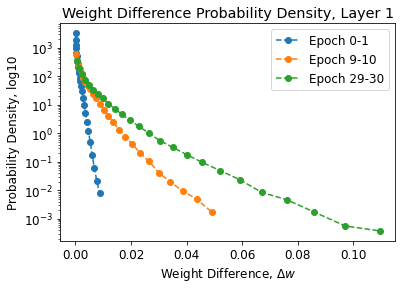

In [17]:
plt.plot(bin_centers_0_1, prob_density_0_1, "o--", label="Epoch 0-1")
plt.plot(bin_centers_9_10, prob_density_9_10, "o--", label="Epoch 9-10")
plt.plot(bin_centers_29_30, prob_density_29_30, "o--", label="Epoch 29-30")

plt.xlabel("Weight Difference, $\Delta w$")
plt.ylabel("Probability Density, log10")
plt.title("Weight Difference Probability Density, Layer 1")
plt.legend()
plt.yscale("log")
#plt.xscale("log")
#plt.xlim(0, 0.01)
#plt.ylim(0, 1000)
plt.show()

Vi ser at når vi plotter alle sannsynlighetstetthetene i samme plot med logaritmisk y-akse er det stor forskjell på vektendringene etter nettverket trenes.

### 17. juli

Prøvde å finne mer ut av den karakteristike størrelsen $\Delta w^*$ som definert øverst i notebooken og hvordan den er definert for de ulike fordelingsfunksjonene. Det viste seg å være vanskelig å finne noe info om bruken av denne slik jeg fikk forklart på oppdateringsmøtet. 

Etter mye tenking gikk jeg over til å prøve pythons innebygde bibliotek for å å finne en eksponentialfunksjon som kunne passe. Jeg vil heller bruke mer tid på den teoretiske fremgangsmåten senere om jeg får tid.

Leste
https://medium.com/the-researchers-guide/finding-the-best-distribution-that-fits-your-data-using-pythons-fitter-library-319a5a0972e9
som en intro til python-tilpasning. 

Fikk lastet opp hele prosjektet på en felles github-repo slik at de andre kan se hva jeg har gjort.

#### Forklaring av speilingsresultatet ovenfor:

For å prøve å forklare hvorfor log-log plottet er diagonalt speilet av det første lin-lin plottet tester jeg videre med eksponentialfunksjonen som definert aller først i notebooken til testing:

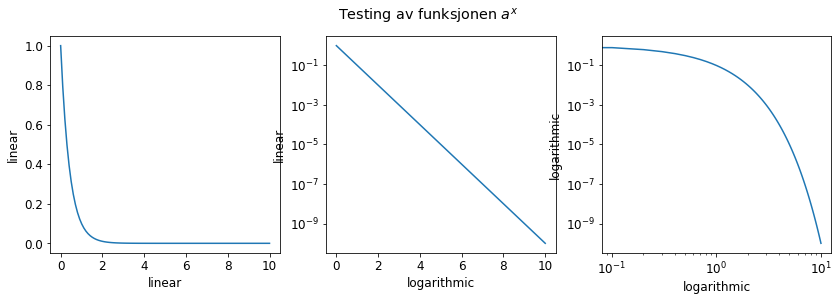

In [90]:
x = np.linspace(0, 10, 100)
def f(x, a):
    return a**x

plt.figure(figsize=(14, 4))
plt.suptitle("Testing av funksjonen $a^x$")

plt.subplot(1, 3, 1)
plt.plot(x, f(x, 0.1))
#plt.title("lin-lin")
plt.ylabel("linear")
plt.xlabel("linear")

plt.subplot(1, 3, 2)
plt.plot(x, f(x, 0.1))
plt.yscale("log")
#plt.title("lin-log")
plt.ylabel("linear")
plt.xlabel("logarithmic")

plt.subplot(1, 3, 3)
plt.plot(x, f(x, 0.1))
plt.xscale("log")
plt.yscale("log")
#plt.title("log-log")
plt.ylabel("logarithmic")
plt.xlabel("logarithmic")
plt.show()

Ser at vi får samme oppførsel med speiling om diagonalen med en eksponetialfunksjon av typen 
$$f(x) = a^x$$
hvor $0<a<1$. Dette kan tyde på at vektfordelingen også er en funksjon av den typen.

#### Annen type fordelingsfunksjon:
Ser at en annen mulig fordelingsfunksjon som kan passe er potenslov-funksjon av typen 
$$f(x) = a x^{-k}$$
som vist i koden under:

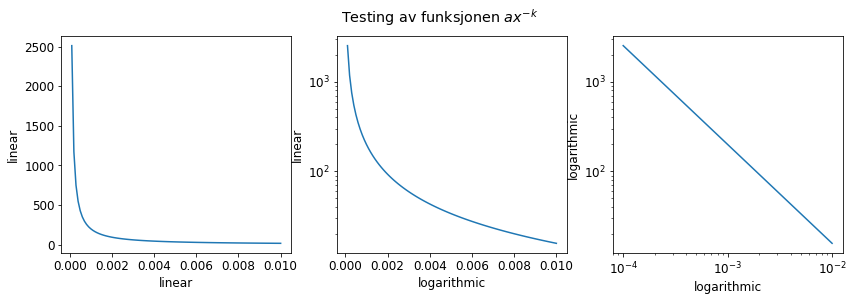

In [93]:
x = np.linspace(0.0001, 0.01, 100)
def f(x, a, k):
    return a*x**(-k)

plt.figure(figsize=(14, 4))
plt.suptitle("Testing av funksjonen $ax^{-k}$")

plt.subplot(1, 3, 1)
plt.plot(x, f(x, 0.1, 1.1))
#plt.title("lin-lin")
plt.ylabel("linear")
plt.xlabel("linear")

plt.subplot(1, 3, 2)
plt.plot(x, f(x, 0.1, 1.1))
plt.yscale("log")
#plt.title("lin-log")
plt.ylabel("linear")
plt.xlabel("logarithmic")

plt.subplot(1, 3, 3)
plt.plot(x, f(x, 0.1, 1.1))
plt.xscale("log")
plt.yscale("log")
#plt.title("log-log")
plt.ylabel("logarithmic")
plt.xlabel("logarithmic")
plt.show()

Ser derimot at funksjonen ikke har samme oppførsel som vektendringsdataen ovenfor og det er derfor ikke sikkert at denne funksjonen vil passe best.

#### Fordelingsfunksjoner med python-bibliotek:

Tester fordelingen $f(x) = ax^{-k}$ med python-biblioteket Fitter. Finner foreløpig ikke en fordelingsfunksjon i scipy sitt bibliotek for $f(x) = a^x$.

In [20]:
import pandas as pd 
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

Fitting 1 distributions: 100%|██████████| 1/1 [00:30<00:00, 30.06s/it]
powerlaw was not fitted. no parameters available
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 0.004)

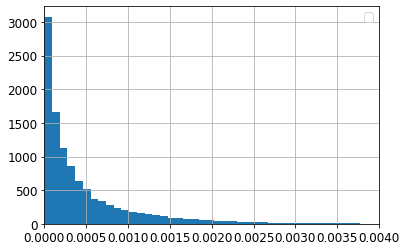

In [21]:
weight_differences_0_1 = np.array(weight_differences_0_1)
f = Fitter(weight_differences_0_1, distributions=["powerlaw"])
f.fit()
f.summary()
plt.xlim(0, 0.004)

Prøver alle mulig fordelinger og ser hvilke som passer best. Denne neste kodebiten kan ta en stund å kjøre.

Fitting 109 distributions:   0%|          | 0/109 [00:00<?, ?it/s]SKIPPED _fit distribution (taking more than 30 seconds)


Fitting 109 distributions:   4%|▎         | 4/109 [00:30<13:47,  7.88s/it]SKIPPED beta distribution (taking more than 30 seconds)
SKIPPED arcsine distribution (taking more than 30 seconds)
SKIPPED betaprime distribution (taking more than 30 seconds)
SKIPPED bradford distribution (taking more than 30 seconds)
Fitting 109 distributions:   7%|▋         | 8/109 [00:30<04:16,  2.54s/it]SKIPPED burr distribution (taking more than 30 seconds)
SKIPPED burr12 distribution (taking more than 30 seconds)
Fitting 109 distributions:  13%|█▎        | 14/109 [01:00<10:07,  6.40s/it]SKIPPED chi2 distribution (taking more than 30 seconds)
SKIPPED crystalball distribution (taking more than 30 seconds)
Fitting 109 distributions:  15%|█▍        | 16/109 [01:00<05:49,  3.76s/it]SKIPPED dgamma distribution (taking more than 30 seconds)
SKIPPED dweibull distribution (taking more than 30 seconds)
Fitting 109 distributions:  17%|█▋        | 18/109 [01:00<03:36,  2.38s/it]SKIPPED erlang distribution (taking more

{'alpha': {'a': 1.8559713020219855,
  'loc': -0.00025523793901028225,
  'scale': 0.0009085120109550977}}

c:\Users\rache\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\integrate\_quadpack_py.py:1151: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


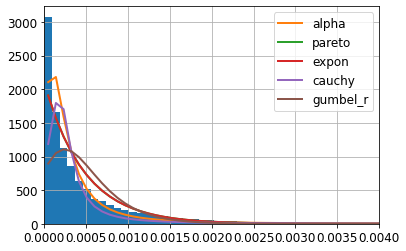

In [22]:
weight_differences_0_1 = np.array(weight_differences_0_1)
f = Fitter(weight_differences_0_1)
f.fit()
f.summary()
plt.xlim(0, 0.004)
f.get_best(method = "sumsquare_error")

Ser at noen av fordelingsfunksjonene som gir best fit er funksjoner sentrert rundt 0, eller normalfordelinger. Siden vi kun ser på absoluttverdien av vektfordelingene passer ikke disse funksjonene like bra, utelater jeg disse.

Prøver også hvordan de vanligste distribusjonene passer til vektfordelingsdataen:

Fitting 10 distributions:  40%|████      | 4/10 [00:12<00:18,  3.16s/it]c:\Users\rache\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\integrate\_quadpack_py.py:1151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
SKIPPED exponpow distribution (taking more than 30 seconds)
Fitting 10 distributions:  50%|█████     | 5/10 [00:32<00:47,  9.45s/it]SKIPPED chi2 distribution (taking more than 30 seconds)
SKIPPED cauchy distribution (taking more than 30 seconds)
Fitting 10 distributions: 100%|██████████| 10/10 [00:35<00:00,  3.53s/it]
exponpow was not fitted. no parameters available


{'expon': {'loc': 0.0, 'scale': 0.00047576031647622585}}

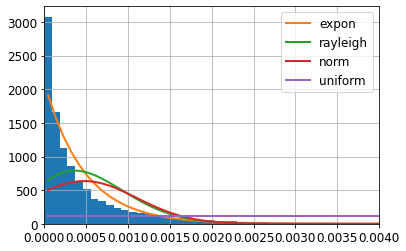

In [23]:
weight_differences_0_1 = np.array(weight_differences_0_1)
f = Fitter(weight_differences_0_1, distributions=get_common_distributions())
f.fit()
f.summary()
plt.xlim(0, 0.004)
f.get_best(method = "sumsquare_error")

Ser at det er eksponentialfunksjonen som passer best av de vanlige fordelingsfunksjonene. Ønsker gjerne å se hvordan powerlaw-funksjonen tilpasser vekfordelingen og prøver derfor å bruke scipy sin curve_fit():

In [24]:
from scipy.optimize import curve_fit

Bruker powerlaw som definert i scipy-manualen:
$$f(x,a) = ax^{a-1}$$

In [25]:
def power_law(x, a):
    return a * x**(a-1) 

In [26]:
x_data = bin_centers_0_1
y_data = prob_density_0_1

popt, pcov = curve_fit(power_law, x_data, y_data)

x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = power_law(x_fit, *popt)

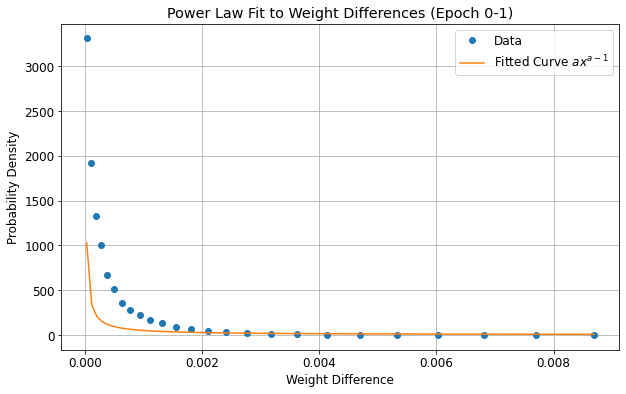

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, "o", label="Data")
plt.plot(x_fit, y_fit, "-", label="Fitted Curve $ax^{a-1}$")
plt.xlabel("Weight Difference")
plt.ylabel("Probability Density")
plt.title("Power Law Fit to Weight Differences (Epoch 0-1)")
plt.legend()
plt.grid()
plt.show()

Får med metoden ovenfor også brukt de økende bin-breddene, men er usikker på om den er helt korrekt da power_law muligens trenger flere parametere?

### 18. juli

Gikk over curve_fit()-metoden en gang til for å se at det ikke var gjort noe galt. Ser at tilnærmingen ikke er den beste. Prøver derfor med en annen type fordelingsfunksjon som jeg i går fant til å ha omtrent samme oppførsel som datasettet, men gjør man om på aksene til lin-log og log-log ser man at man får lineær-fordeling ved log-log, mens det faktiske vekfordelingsdatasettet får lineær fordeling ved lin-log.

Prøver likevel powerlaw av typen 
$$f(x,a,k) = ax^{-k}$$

Tester hvordan fordelingen passer med vektfordelingen mellom epoke 0-1, 9-10 og 29-30:

In [96]:
def power_law1(x, a, k):
    return a * x**(-k)

In [97]:
x_data_0_1 = bin_centers_0_1
y_data_0_1 = prob_density_0_1

popt_0_1, pcov_0_1 = curve_fit(power_law1, x_data_0_1, y_data_0_1)

x_fit_0_1 = np.linspace(min(x_data_0_1), max(x_data_0_1), 100)
y_fit_0_1 = power_law1(x_fit_0_1, *popt_0_1)

In [98]:
x_data_9_10 = bin_centers_9_10
y_data_9_10 = prob_density_9_10

popt_9_10, pcov_9_10 = curve_fit(power_law1, x_data_9_10, y_data_9_10)

x_fit_9_10 = np.linspace(min(x_data_9_10), max(x_data_9_10), 100)
y_fit_9_10 = power_law1(x_fit_9_10, *popt_9_10)

In [99]:
x_data_29_30 = bin_centers_29_30
y_data_29_30 = prob_density_29_30

popt_29_30, pcov_29_30 = curve_fit(power_law1, x_data_29_30, y_data_29_30)

x_fit_29_30 = np.linspace(min(x_data_29_30), max(x_data_29_30), 100)
y_fit_29_30 = power_law1(x_fit_29_30, *popt_29_30)

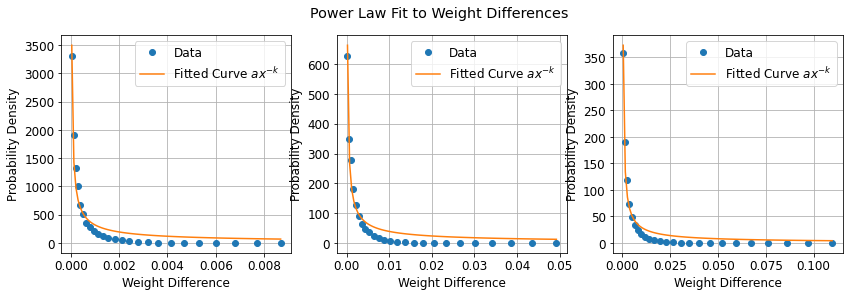

In [100]:
plt.figure(figsize=(14, 4))
plt.suptitle("Power Law Fit to Weight Differences")

plt.subplot(1, 3, 1)
plt.plot(x_data_0_1, y_data_0_1, "o", label="Data epoch 0-1")
plt.plot(x_fit_0_1, y_fit_0_1, "-", label="Fitted Curve $ax^{-k}$")
plt.xlabel("Weight Difference")
plt.ylabel("Probability Density")
#plt.title("Power Law Fit to Weight Differences (Epoch 0-1)")
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(x_data_9_10, y_data_9_10, "o", label="Data epoch 9-10")
plt.plot(x_fit_9_10, y_fit_9_10, "-", label="Fitted Curve $ax^{-k}$")
plt.xlabel("Weight Difference")
plt.ylabel("Probability Density")
#plt.title("Power Law Fit to Weight Differences (Epoch 9-10)")
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(x_data_29_30, y_data_29_30, "o", label="Data epoch 29-30")
plt.plot(x_fit_29_30, y_fit_29_30, "-", label="Fitted Curve $ax^{-k}$")
plt.xlabel("Weight Difference")
plt.ylabel("Probability Density")
#plt.title("Power Law Fit to Weight Differences (Epoch 29-30)")
plt.legend()
plt.grid()
plt.show()

Ser ut som om denne fordelingsfunksjonen passer relativt bra for alle de ulike epokene, men skulle gjerne funnet en fordelingsfunksjon som traff enda bedre. Tester også eksponentialfunksjon på formen
$f(x,a,b) = ae^{-bx}$
og 
$f(x) = a^x$
da jeg tror spesielt $a^x$ vil passe bedre basert på funksjonsoppførselen med logaitmisk og delvis logaritmisk skala. Jeg ser dog i etterkant at $a^x$ kun er en god tilpasning når $0<a<1$ og verdiene på aksene i plottene for funksjonen som kan finnes ovenfor er ikke av samme størrelsesorden som verdiene på aksene til vektfordelingsplottet. Det er dermed ikke sikkert at denne funksjonen er en god fordelingsfunksjon til dataen likevel.

In [62]:
def exp(x, a, b):
    return a * np.exp(-b * x)

def exp2(x, a, b, c):
    return a**(x*b) + c

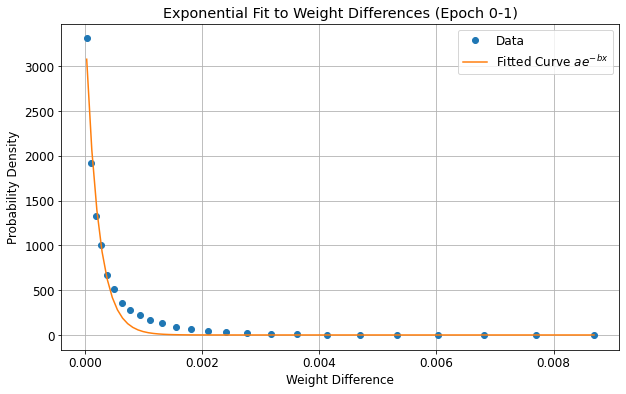

In [76]:
x_data = bin_centers_0_1
y_data = prob_density_0_1

popt1, pcov1 = curve_fit(exp, x_data, y_data)
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit1 = exp(x_fit, *popt1)

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, "o", label="Data")
plt.plot(x_fit, y_fit1, "-", label="Fitted Curve $ae^{-bx}$")
plt.xlabel("Weight Difference")
plt.ylabel("Probability Density")
plt.title("Exponential Fit to Weight Differences (Epoch 0-1)")
plt.legend()
plt.grid()
plt.show()

In [77]:
print(pcov1)

[[21462.41752581 31217.57074957]
 [31217.57074957 86282.69902198]]


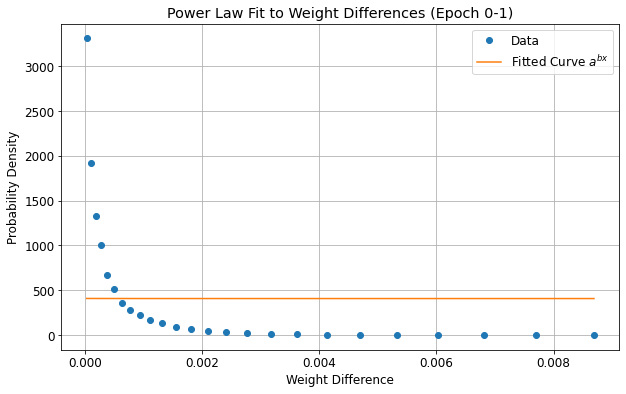

In [37]:
x_data = bin_centers_0_1
y_data = prob_density_0_1

popt2, pcov2 = curve_fit(exp2, x_data, y_data, maxfev=10000)

x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit2 = exp2(x_fit, *popt2)

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, "o", label="Data")
plt.plot(x_fit, y_fit2, "-", label="Fitted Curve $a^{bx}$")
plt.xlabel("Weight Difference")
plt.ylabel("Probability Density")
plt.title("Power Law Fit to Weight Differences (Epoch 0-1)")
plt.legend()
plt.grid()
plt.show()

Det viser seg å være vanskeligere enn antatt å tilpasse en fordelingsfunksjon av typen $f(x, a) = a^x$. Prøver å finne ut av hvordan, men er ikke lenger sikker på om det er den typen funksjon som vil passe best som forklart tidligere. I prøvinga fikk jeg tilpasset eksponentialfunksjonen $f(x, a, b) = a e^{-bx}$ som også passer relativt bra.

Leste litt om least squares metoden og hvordan den kan brukes med scipy.

### 19. Juli

Prøver videre å log-transformere vektfordelingsdataen slik at vi får en lineær fordeling av data og dermed kan gjøre en lineærregresjon. 

stigningstall =  -625.3489189494264
konstantledd =  3.0568281784193188
error =  12.782823238161498


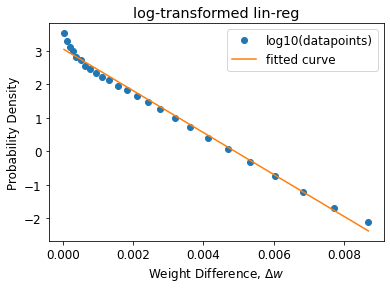

In [54]:
from scipy.stats import linregress

l = linregress(bin_centers_0_1, np.log10(prob_density_0_1))

stigningstall = l.slope
konstantledd = l.intercept
print("stigningstall = ", stigningstall)
print("konstantledd = ", konstantledd)
print("error = ", l.stderr)

def linje(x, a, b):
    return x*a + b

x_fit = np.linspace(min(bin_centers_0_1), max(bin_centers_0_1), 1000)
log_y_fit = linje(x_fit, l.slope, l.intercept)

plt.plot(bin_centers_0_1, np.log10(prob_density_0_1), "o", label="log10(datapoints)")
plt.plot(x_fit, log_y_fit, label="fitted curve")

plt.legend()
plt.title("log-transformed lin-reg")
plt.xlabel("Weight Difference, $\Delta w$")
plt.ylabel("Probability Density")
plt.show()

Ser at dataen ikke er helt lineærfordelt, men kurver litt oppover i hjørnet øverst til venstre. 

Tester ut om fordelingen $f(x,a,b) = ae^{-bx}$ som testet for vektendringen mellom epoke 0-1 tidligere passer like bra for vektendringen mellom epoke 9-10 og 29-30. Finner også verdiene til parameterene $a$ og $b$ med tilhørende usikkerhet.

Fra scipy sin curve_fit henter vi ut parametereen $a$ og $b$ fra popt1 og usikkerheten fra pcov1. Usikkerheten til parameterene ligger langs diagonalen til pcov1-matrisen og tar man roten av disse får man et estimat av feilen til parameterne.

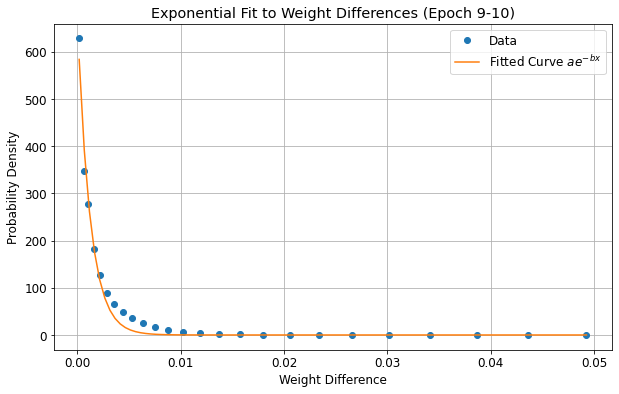

The value of a is 685.13221 with standard error of 26.18869.
The value of b is 810.55484 with standard error of 49.08177.


In [92]:
x_data = bin_centers_9_10
y_data = prob_density_9_10

popt_9_10, pcov_9_10 = curve_fit(exp, x_data, y_data)
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit1 = exp(x_fit, *popt_9_10)

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, "o", label="Data")
plt.plot(x_fit, y_fit1, "-", label="Fitted Curve $ae^{-bx}$")
plt.xlabel("Weight Difference")
plt.ylabel("Probability Density")
plt.title("Exponential Fit to Weight Differences (Epoch 9-10)")
plt.legend()
plt.grid()
plt.show()

stdr = np.sqrt(np.diag(pcov_9_10))
stdr_a = stdr[0]
stdr_b = stdr[1]

print(F'The value of a is {popt_9_10[0]:.5f} with standard error of {stdr_a:.5f}.')
print(F'The value of b is {popt_9_10[1]:.5f} with standard error of {stdr_b:.5f}.')

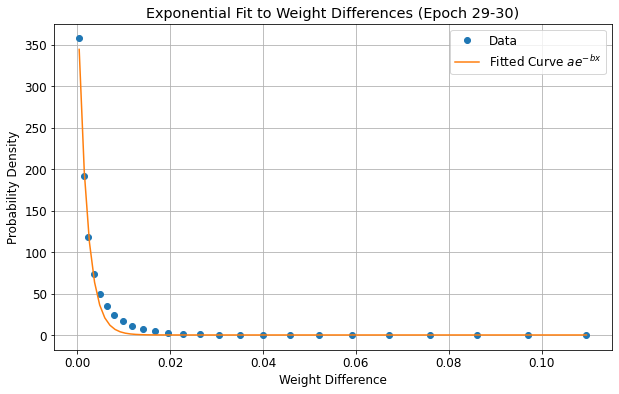

The value of A is 431.12361 with standard error of 13.80326.
The value of B is 510.49786 with standard error of 24.89754.


In [65]:
x_data = bin_centers_29_30
y_data = prob_density_29_30

popt_29_30, pcov_29_30 = curve_fit(exp, x_data, y_data)
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit1 = exp(x_fit, *popt_29_30)

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, "o", label="Data")
plt.plot(x_fit, y_fit1, "-", label="Fitted Curve $ae^{-bx}$")
plt.xlabel("Weight Difference")
plt.ylabel("Probability Density")
plt.title("Exponential Fit to Weight Differences (Epoch 29-30)")
plt.legend()
plt.grid()
plt.show()

stdr = np.sqrt(np.diag(pcov_29_30))
stdr_a = stdr[0]
stdr_b = stdr[1]

print(F'The value of a is {popt_29_30[0]:.5f} with standard error of {stdr_a:.5f}.')
print(F'The value of b is {popt_29_30[1]:.5f} with standard error of {stdr_b:.5f}.')

Ser at usikkerheten i parameterne er mye større enn ønsket. Ser etter å ha lest litt videre om curve_fit() og det hadde kanskje vært en fordel å definere noen startparametere ved $p0=[]$ i curve_fit()-funksjonen.

Prøver til slutt med noen flere fordelingsfunksjoner ved å definere funksjonen "model" under og ser om jeg finner noen som passer bedre. Prøver også pareto-fordelingen da jeg så ved fitted-biblioteket tidligere at den var en av de bedre tilpasningene til dataen.

In [86]:
def model(x, a, b):
    return a * x**(-b*x)

def pareto(x, b):
    return b / (x**(b+1))

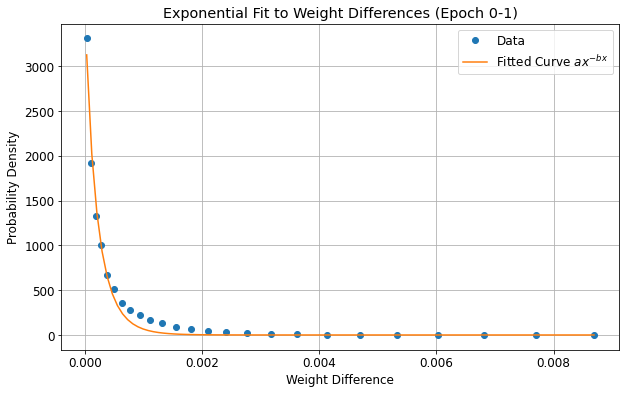

The value of a is 3859.46159 with standard error of 131.66271.
The value of b is -588.20710 with standard error of 28.79923.


In [107]:
x_data = bin_centers_0_1
y_data = prob_density_0_1

popt1, pcov1 = curve_fit(model, x_data, y_data)
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit1 = model(x_fit, *popt1)

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, "o", label="Data")
plt.plot(x_fit, y_fit1, "-", label="Fitted Curve $ax^{-bx}$")
plt.xlabel("Weight Difference")
plt.ylabel("Probability Density")
plt.title("Exponential Fit to Weight Differences (Epoch 0-1)")
plt.legend()
plt.grid()
plt.show()

stdr = np.sqrt(np.diag(pcov1))
stdr_a = stdr[0]
stdr_b = stdr[1]

print(F'The value of a is {popt1[0]:.5f} with standard error of {stdr_a:.5f}.')
print(F'The value of b is {popt1[1]:.5f} with standard error of {stdr_b:.5f}.')

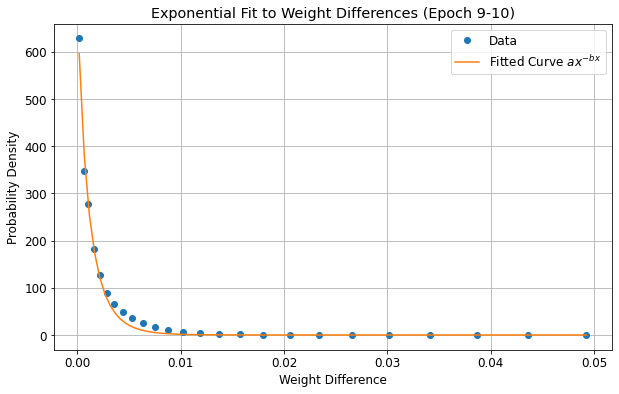

The value of a is 749.13692 with standard error of 22.62663.
The value of b is -135.33286 with standard error of 5.69202.


In [108]:
x_data = bin_centers_9_10
y_data = prob_density_9_10

popt1, pcov1 = curve_fit(model, x_data, y_data)
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit1 = model(x_fit, *popt1)

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, "o", label="Data")
plt.plot(x_fit, y_fit1, "-", label="Fitted Curve $ax^{-bx}$")
plt.xlabel("Weight Difference")
plt.ylabel("Probability Density")
plt.title("Exponential Fit to Weight Differences (Epoch 9-10)")
plt.legend()
plt.grid()
plt.show()

stdr = np.sqrt(np.diag(pcov1))
stdr_a = stdr[0]
stdr_b = stdr[1]

print(F'The value of a is {popt1[0]:.5f} with standard error of {stdr_a:.5f}.')
print(F'The value of b is {popt1[1]:.5f} with standard error of {stdr_b:.5f}.')

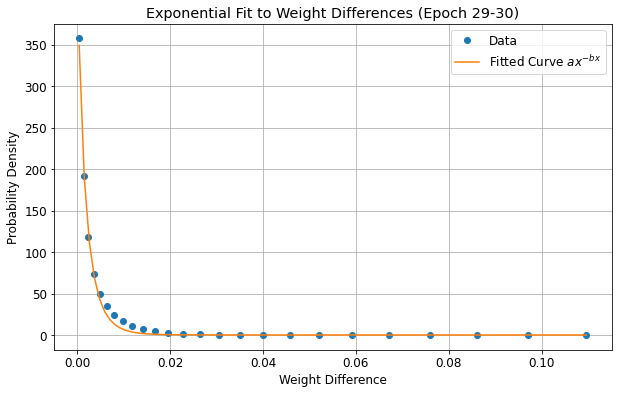

The value of a is 479.31693 with standard error of 10.77605.
The value of b is -93.18274 with standard error of 2.75349.


In [101]:
x_data = bin_centers_29_30
y_data = prob_density_29_30

popt1, pcov1 = curve_fit(model, x_data, y_data)
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit1 = model(x_fit, *popt1)

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, "o", label="Data")
plt.plot(x_fit, y_fit1, "-", label="Fitted Curve $ax^{-bx}$")
plt.xlabel("Weight Difference")
plt.ylabel("Probability Density")
plt.title("Exponential Fit to Weight Differences (Epoch 29-30)")
plt.legend()
plt.grid()
plt.show()

stdr = np.sqrt(np.diag(pcov1))
stdr_a = stdr[0]
stdr_b = stdr[1]

print(F'The value of a is {popt1[0]:.5f} with standard error of {stdr_a:.5f}.')
print(F'The value of b is {popt1[1]:.5f} with standard error of {stdr_b:.5f}.')

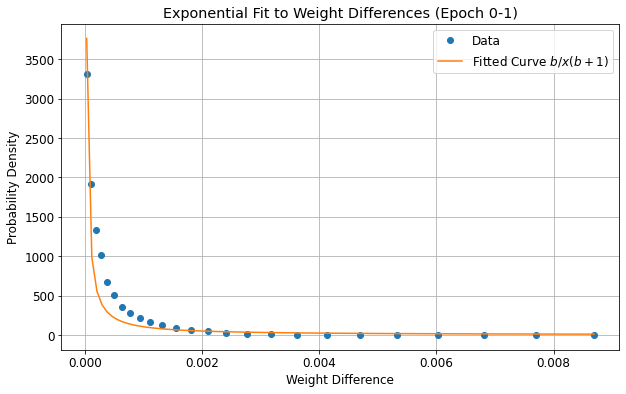

The value of b is 0.06636 with standard error of 0.00288.


In [109]:
x_data = bin_centers_0_1
y_data = prob_density_0_1

popt1, pcov1 = curve_fit(pareto, x_data, y_data)
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit1 = pareto(x_fit, *popt1)

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, "o", label="Data")
plt.plot(x_fit, y_fit1, "-", label="Fitted Curve ${b}/{x(b+1)}$")
plt.xlabel("Weight Difference")
plt.ylabel("Probability Density")
plt.title("Exponential Fit to Weight Differences (Epoch 0-1)")
plt.legend()
plt.grid()
plt.show()

stdr = np.sqrt(np.diag(pcov1))
stdr_b = stdr[0]

print(F'The value of b is {popt1[0]:.5f} with standard error of {stdr_b:.5f}.')

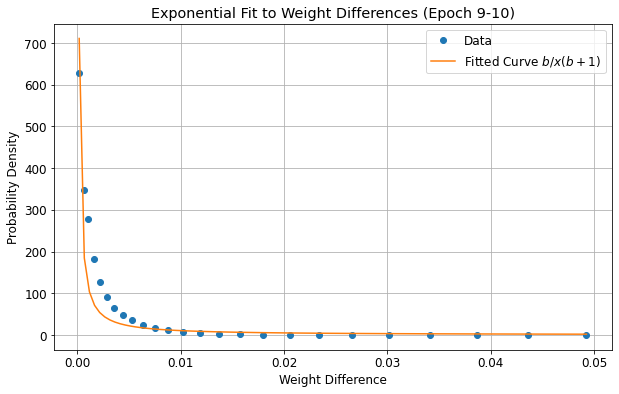

The value of b is 0.07442 with standard error of 0.00337.


In [110]:
x_data = bin_centers_9_10
y_data = prob_density_9_10

popt1, pcov1 = curve_fit(pareto, x_data, y_data)
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit1 = pareto(x_fit, *popt1)

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, "o", label="Data")
plt.plot(x_fit, y_fit1, "-", label="Fitted Curve ${b}/{x(b+1)}$")
plt.xlabel("Weight Difference")
plt.ylabel("Probability Density")
plt.title("Exponential Fit to Weight Differences (Epoch 9-10)")
plt.legend()
plt.grid()
plt.show()

stdr = np.sqrt(np.diag(pcov1))
stdr_b = stdr[0]

print(F'The value of b is {popt1[0]:.5f} with standard error of {stdr_b:.5f}.')

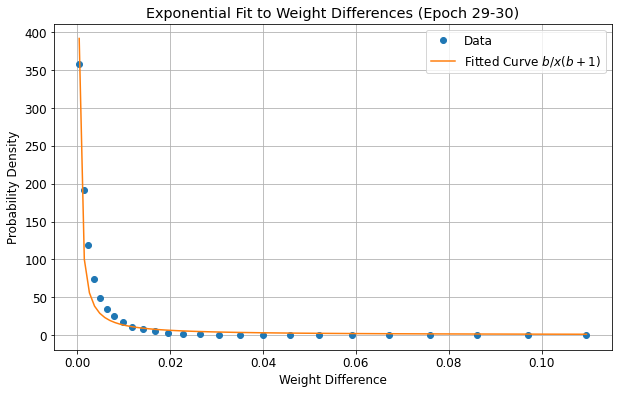

The value of b is 0.08757 with standard error of 0.00286.


In [106]:
x_data = bin_centers_29_30
y_data = prob_density_29_30

popt1, pcov1 = curve_fit(pareto, x_data, y_data)
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit1 = pareto(x_fit, *popt1)

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, "o", label="Data")
plt.plot(x_fit, y_fit1, "-", label="Fitted Curve ${b}/{x(b+1)}$")
plt.xlabel("Weight Difference")
plt.ylabel("Probability Density")
plt.title("Exponential Fit to Weight Differences (Epoch 29-30)")
plt.legend()
plt.grid()
plt.show()

stdr = np.sqrt(np.diag(pcov1))
stdr_b = stdr[0]

print(F'The value of b is {popt1[0]:.5f} with standard error of {stdr_b:.5f}.')

Etter mye prøving og feiling med ulike fordelingsfunksjoner er de to som kommer best ut $f(x, a, b) = ae^{-bx}$ og $f(x, a, b) = ax^{-bx}$ hvor sistnevnte traff litt bedre basert på forholdet mellom parameter og usikkerhet. Vi kan se at fordelingsfunksjonen treffer dataen litt bedre desto flere epoker det har gått.